# Retrieve spectra using Simple Spectral Access protocol

This notebook is one of a set produced by NAVO to demonstrate data access with python tools. If you have not already, start with the [overview notebook](Overview.ipynb).

In this notebook, we show how to search for and retrieve spectra from VO services using the Registry and the __[Simple Spectral Access](http://www.ivoa.net/documents/SSA/)__ (SSA) protocol.


In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline  
import requests, io
from astropy.table import Table
import astropy.io.fits as fits

from navo_utils.registry import Registry
from navo_utils.spectra import Spectra, SpectraColumn

from astropy.coordinates import SkyCoord

## There are a number of relatively unimportant warnings that 
## show up, so for now, suppress them:
import warnings
warnings.filterwarnings("ignore")

First, we find out what spectral acess services are available in the Registry offering x-ray data:

In [3]:
services=Registry.query(service_type='spectr',waveband='x-ray')
services

<Table masked=True length=4>
                        waveband                         ...
                         str56                           ...
-------------------------------------------------------- ...
                                         x-ray#gamma-ray ...
radio#millimeter#infrared#optical#uv#euv#x-ray#gamma-ray ...
                                         gamma-ray#x-ray ...
                                                   x-ray ...

We can look at only the Chandra entry:

In [4]:
chan_tables = services[np.isin(services['short_name'],['Chandra'])]
chan_tables['short_name', 'access_url']

<Table masked=True length=1>
short_name                            access_url                           
  str14                                 str71                              
---------- ----------------------------------------------------------------
   Chandra https://heasarc.gsfc.nasa.gov/xamin/vo/ssa?table=chanmaster&amp;

## Chandra Spectrum of the Delta Ori

In [5]:
delori=SkyCoord.from_name("delta ori")
pos='{},{}'.format(delori.ra.deg,delori.dec.deg)

spec_tables=Spectra.query(service=chan_tables[0],coords=pos,radius=0.1,verbose=True)

spec_tables[0]['time'].format='.4f'
spec_tables[0].show_in_notebook()



    Querying service https://heasarc.gsfc.nasa.gov/xamin/vo/ssa?table=chanmaster&amp;
    Got 6 results for parameters[0]


In [6]:
hdu_list=Spectra.get_fits(spec_tables[0][5])
# Or write it to disk
Spectra.get_fits(spec_tables[0][5],filename='downloads/chandra_spectrum.fits')

FITS spectrum written to downloads/chandra_spectrum.fits



## Simple example of plotting a spectrum

In [7]:
spec_table=Table(hdu_list[1].data)
spec_table

<Table length=12>
SPEC_NUM  TG_M ...              BIN_HI [8192]              
 int16   int16 ...                 float64                 
-------- ----- ... ----------------------------------------
       1    -3 ... 7.160000000000712 .. 0.33416666666666667
       2    -2 ...            10.740000000000887 .. 0.50125
       3    -1 ...             21.480000000001773 .. 1.0025
       4     1 ...             21.480000000001773 .. 1.0025
       5     2 ...            10.740000000000887 .. 0.50125
       6     3 ... 7.160000000000712 .. 0.33416666666666667
       7    -3 ... 13.98666666666804 .. 0.33499999999999996
       8    -2 ...             20.980000000001507 .. 0.5025
       9    -1 ...              41.960000000003014 .. 1.005
      10     1 ...              41.960000000003014 .. 1.005
      11     2 ...             20.980000000001507 .. 0.5025
      12     3 ... 13.98666666666804 .. 0.33499999999999996

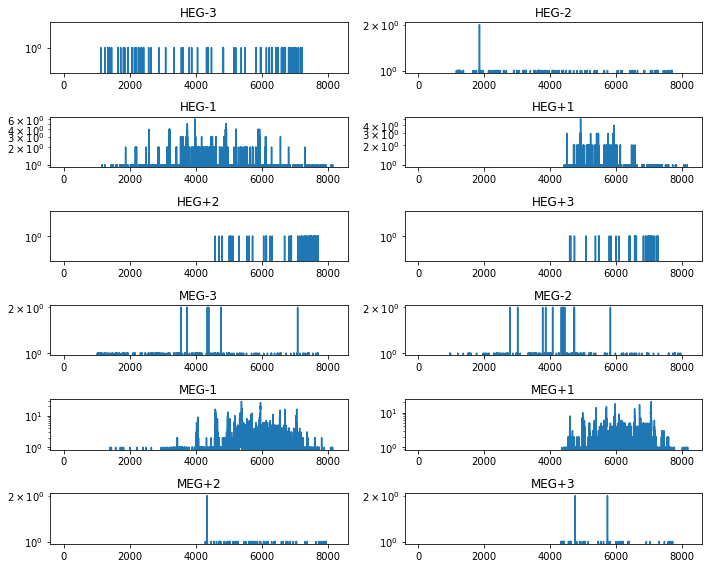

In [8]:
for i in range(len(spec_table)):
    matplotlib.rcParams['figure.figsize'] = (10, 8)
    ax=plt.subplot(6,2,i+1)
    pha = plt.plot( spec_table['CHANNEL'][i],spec_table['COUNTS'][i])
    ax.set_yscale('log')
    if spec_table['TG_PART'][i] == 1:
        instr='HEG'
    if spec_table['TG_PART'][i] == 2:
        instr='MEG'
    if spec_table['TG_PART'][i] == 3:
        instr='LEG'
    ax.set_title("{grating}{order:+d}".format(grating=instr, order=spec_table['TG_M'][i]))
    plt.tight_layout()


## <font color=red> Antara: This is still not very exciting but then if we follow the necessary steps to make a pretty spectrum, we are deviating from the VO stuff and veering into plotting and PyXSPEC tutorial. Not sure if we should continue or not. Also VO doesn't provide the necessary response file so we need to use stored files... </font>

### Continuing with making a pretty spectrum, but this now requires PyXSPEC, response files (in the data directory): 



In [11]:
import xspec
## For capturing Xspec terminal output
##  See https://github.com/minrk/wurlitzer
from wurlitzer import sys_pipes
xspec.Xset.allowPrompting = False # keeps pyxspec from hanging, waiting for a response to a prompt
##  The type II PHA files contain multiple spectra, and we tell Xspec to select with the 
##  curly bracket notation and the number starting from 1 (not zero):
with sys_pipes():
    pha = xspec.Spectrum("downloads/chandra_spectrum.fits{10}")
    ##  As mentioned above, this is retrieved off-line for now.
    #pha.response="tgcat/obs_19792_tgid_5277/heg_1.rmf.gz"
    #pha.response.arf="tgcat/obs_19792_tgid_5277/heg_1.arf.gz"    
    #pha.response="tgcat/obs_19792_tgid_5277/meg_1.rmf.gz"
    #pha.response.arf="tgcat/obs_19792_tgid_5277/meg_1.arf.gz"
    pha.response="aux/my_rmf.fits.gz"
    pha.response.arf="aux/my_arf.fits.gz"

ModuleNotFoundError: No module named 'chain'

In [ ]:
with sys_pipes():
    m = xspec.Model("tbabs*po+ga")